In [8]:
%%bash
pip install planetary-computer==0.3.0rc3 \
pystac==1.0.0 \
pystac-client==0.2.0-beta.2 \
rasterio==1.2.6 \
rtree==0.9.7 \
fastparquet
# dask[complete]==2021.7.1 \
# dask-geopandas==0.1.0a4 \

  Created wheel for thrift: filename=thrift-0.13.0-cp38-cp38-linux_x86_64.whl size=413928 sha256=2923246bfcfa4e3e0d5a2ac8d708a5c931977da34a5d0c7990162f4f2c70d272
  Stored in directory: /home/jovyan/.cache/pip/wheels/0a/52/7e/8054b57725b8f2b9ddbaacb81b271b939681cc03f8231e6ebc
Successfully built thrift


In [2]:
import pystac
# needs to be 1.0.0 for pystac.extensions.eo to work
print(pystac.__version__)

1.0.0


In [88]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

In [4]:
import dask.dataframe as dd
from adlfs import AzureBlobFileSystem

# Not used directly, but either fastparquet or pyarrow needs to be installed
# import fastparquet

storage_account_name = 'cpdataeuwest'
folder_name = 'cpdata/raw/fia'

fs = AzureBlobFileSystem(account_name=storage_account_name)
parquet_files = fs.glob(folder_name + '/*parquet')


In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [9]:
filename = 'plot'
df = dd.read_parquet(f'az://{folder_name}/{filename}.parquet',
                     storage_options={'account_name':storage_account_name}).compute()
df.head()
#filter here for data only in sentinel range
df = df[df['MEASYEAR']>2014]
df['DATETIME'] = [pd.to_datetime(f"{int(i['MEASYEAR'])}-{int(i['MEASMON'])}-{int(i['MEASDAY'])}", format='%Y-%m-%d') for _,i in df.iterrows()]

In [10]:
# import pandas as pd
# import geopandas as gpd
# import numpy as np

def apply_buffer_to_points(df, buffer_distance, buffer_type='square', resolution=1):
    buffer_style = {'round':1, 'flat':2, 'square':3}
    srcdf = df.copy()
    srcdf = srcdf.to_crs('EPSG:3857')
    srcdf['geometry'] = srcdf.geometry.buffer(buffer_distance,\
                                           cap_style=buffer_style[buffer_type],\
                                           resolution=resolution)
    srcdf = srcdf.to_crs('EPSG:4326')
    df = df.set_geometry(srcdf.geometry)
    return(df)

def create_daterange(df,month=6,day=30):
    daterange = [f"{int(r['DATETIME'].strftime('%Y'))-1}-{month}-{day}/{int(r['DATETIME'].strftime('%Y'))}-{month}-{day}" for i,r in df.iterrows()]
    return daterange

def create_aoi(geometry):
    coordinates =  np.dstack(geometry.boundary.coords.xy).tolist()
    area_of_interest = {
    "type": "Polygon",
    "coordinates": coordinates,
    }
    return area_of_interest

In [169]:
# @dask.delayed
# def create_daterange(row,month=6,day=30):
#     return f"{int(row['DATETIME'].strftime('%Y'))-1}-{month}-{day}/{int(row['DATETIME'].strftime('%Y'))}-{month}-{day}"
# @dask.delayed
# def create_aoi(geometry):
#     coordinates =  np.dstack(geometry.boundary.coords.xy).tolist()
#     area_of_interest = {
#     "type": "Polygon",
#     "coordinates": coordinates,
#     }
#     return area_of_interest

In [179]:
# daskified. not sure if it's faster yet
# def make_gdf(df):
#     daterange = [create_daterange(r) for _,r in df.iterrows()]
#     df['DATERANGE'] = dask.compute(*daterange)
#     selections = ['CN', 'INVYR', 'LAT', 'LON', 'DATETIME', 'DATERANGE']
#     subdf = df[selections].dropna()
#     gdf = gpd.GeoDataFrame(
#         subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))
#     gdf = gdf.set_crs('EPSG:4326')
#     buffer_distance = 640 #buffer distance of 640m to attain a 64x64 chip at 10m resolution
#     gdf = apply_buffer_to_points(gdf, buffer_distance)
#     aoi = [create_aoi(i['geometry']) for _,i in gdf.iterrows()]
#     gdf['AOI'] = dask.compute(*aoi)
#     return gdf

In [12]:
#create the time-of-interest
df['DATERANGE'] = create_daterange(df)

selections = ['CN', 'INVYR', 'LAT', 'LON', 'DATETIME', 'DATERANGE']

subdf = df[selections].dropna()
gdf = gpd.GeoDataFrame(
    subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))

gdf = gdf.set_crs('EPSG:4326')

buffer_distance = 6400 #buffer distance of 6400m to attain a 640x640 chip at 10m resolution
gdf = apply_buffer_to_points(gdf, buffer_distance)
#create the area-of-interest
gdf['AOI'] = [create_aoi(i['geometry']) for _,i in gdf.iterrows()]

### Daskified: Iterate through AOI and TOI of FIA samples, return HREFs for image chips from the catalog
Define both the area of interest and define the time range to filter images with. <br/>
Use [pystac-client](https://github.com/stac-utils/pystac-client) to search for Sentinel 2 L2A data the range of the sample

In [21]:
import sys
sys.path.insert(0, '/home/jovyan/data-ingestion/')
from utils.dask import create_cluster

In [93]:
cluster.shutdown()

In [94]:
cluster.status

'closed'

In [79]:
cluster_args = dict(
    workers=2,
    worker_threads=1,
    worker_memory=4,
    scheduler_threads=4,
    scheduler_memory=4
)
cluster = create_cluster(**cluster_args)

In [80]:
cluster

In [81]:
cluster_client = cluster.get_client()

In [82]:
cluster_client

Client Scheduler: gateway://traefik-dhub-dask-gateway.default:80/default.31ff3a580855472dbe1c06a62fcd6d63 Dashboard: /services/dask-gateway/clusters/default.31ff3a580855472dbe1c06a62fcd6d63/status,Cluster Workers: 2 Cores: 2 Memory: 8.59 GB


In [28]:
# ## TEST DASK
# import dask.array as da

# x = da.random.random((10000, 10000), chunks ="16 MiB")
# x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1250, 1250), chunktype=numpy.ndarray>

In [29]:
# y = (x + x.T) - x.mean(axis=0)

In [30]:
# result = y.sum()
# result.compute()

49999751.66638163

In [193]:
# # initialize dask cluster (not tested)
# import os
# import fiona.transform
# import fsspec
# import xarray as xr
# from affine import Affine
# cluster_args = dict(
#     workers=16,
#     worker_threads=3,
#     worker_memory=16,
#     scheduler_threads=4,
#     scheduler_memory=8
# )

# cluster = GatewayCluster(
#     worker_cores=cluster_args['worker_threads'],
#     worker_memory=cluster_args['worker_memory'],
#     )
# cluster.scale(cluster_args['workers'])
# print("Cluster dashboard visible at %s", cluster.dashboard_link)
# cluster_client = cluster.get_client()

In [71]:
# !pip install pystac-client

In [247]:
import dask
from pystac_client import Client as pystacClient
# @dask.delayed
def search_catalogue(area_of_interest, time_of_interest):
    catalog = pystacClient.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=area_of_interest,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 100}},
    )

    # Check how many items were returned
    return list(search.get_items())

In [126]:
# @dask.delayed
def get_asset_href(item, asset='visual'):
    asset_href = item.assets[asset].href
    return pc.sign(asset_href)

In [115]:
def collect_items(gdf):
    items = []
    for i,_ in gdf.iterrows():
        area_of_interest = gdf['AOI'].iloc[i]
        time_of_interest = gdf['DATERANGE'].iloc[i]
        items.append(search_catalogue(area_of_interest, time_of_interest))
    return items

In [144]:
def collect_hrefs(items, *bands):
    bands = [*bands]
    hrefs = []
    for _,itemlist in enumerate(items):
        for b in bands:
            hrefs.append([(b, get_asset_href(item, b)) for _,item in enumerate(itemlist)])
    return hrefs

#### just try with joblib instead of dask for now
until aks cluster has the dependencies dask needs

In [ ]:
# def collect_items(gdf_row):
#     area_of_interest = gdf_row['AOI']
#     time_of_interest = gdf_row['DATERANGE']
#     return search_catalogue(area_of_interest, time_of_interest)

In [162]:
def collect_hrefs(itemlist, *bands):
    bands = [*bands]
    hrefs = []
    for b in bands:
        hrefs.append([(b, get_asset_href(item, b)) for _,item in enumerate(itemlist)])
    return hrefs

In [173]:
gdf_sample['AOI']

0    {'type': 'Polygon', 'coordinates': [[[-88.2771...
1    {'type': 'Polygon', 'coordinates': [[[-88.3552...
2    {'type': 'Polygon', 'coordinates': [[[-87.0933...
Name: AOI, dtype: object

In [206]:
gdf_sample = gdf.head(50).reset_index()
bands = ['AOT', 'B02', 'B03', 'B04', 'B08', 'visual', 'WVP']

In [225]:
from joblib import Parallel, delayed
import datetime


def collect_hrefs(itemlist, *bands):
    bands = [*bands]
    hrefs = []
    for b in bands:
        hrefs.append([(b, get_asset_href(item, b)) for _,item in enumerate(itemlist)])
    return hrefs

begin_time = datetime.datetime.now()

sample_items = Parallel(n_jobs=-1)(delayed(search_catalogue)(row['AOI'], row['DATERANGE']) for _,row in gdf_sample.iterrows())
sample_hrefs = Parallel(n_jobs=-1)(delayed(collect_hrefs)(itemlist, *bands) for _,itemlist in enumerate(sample_items))
print(datetime.datetime.now() - begin_time)


0:00:12.608743


In [208]:
# from joblib import Parallel, delayed
import datetime

def collect_hrefs(items, *bands):
    bands = [*bands]
    hrefs = []
    for _,itemlist in enumerate(items):
        for b in bands:
            hrefs.append([(b, get_asset_href(item, b)) for _,item in enumerate(itemlist)])
    return hrefs

begin_time = datetime.datetime.now()
sample_items = collect_items(gdf_sample)
sample_hrefs = collect_hrefs(sample_items, *bands)
print(datetime.datetime.now() - begin_time)


0:00:33.798129


##### joblib on full data and export to az blob storage

In [245]:
import pandas as pd

In [242]:
import getpass

ACCOUNT_NAME = getpass.getpass('Enter Azure storage account name:')
ACCOUNT_KEY = getpass.getpass('Enter Azure storage account key:')

storage_options = {"account_name": ACCOUNT_NAME, "account_key": ACCOUNT_KEY}

Enter Azure storage account name: ····
Enter Azure storage account key: ························································································


In [246]:
from joblib import Parallel, delayed

bands = ['AOT', 'B02', 'B03', 'B04', 'B08', 'visual', 'WVP']

def collect_hrefs(itemlist, *bands):
    bands = [*bands]
    hrefs = []
    for b in bands:
        hrefs.append([(b, get_asset_href(item, b)) for _,item in enumerate(itemlist)])
    return hrefs

items = Parallel(n_jobs=-1)(delayed(search_catalogue)(row['AOI'], row['DATERANGE']) for _,row in gdf.iterrows())
hrefs = Parallel(n_jobs=-1)(delayed(collect_hrefs)(itemlist, *bands) for _,itemlist in enumerate(items))

APIError: <html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>nginx</center>
</body>
</html>


In [ ]:
from itertools import chain

def band_href_df(hrefs_list):
    return pd.DataFrame(list(chain(*list(chain(*hrefs_list)))), columns=['band', 'href'])

In [ ]:
hrefs_df = band_href_df(hrefs)

In [ ]:
hrefs_df.to_csv('az://sentinel/hrefs/sentinel-2_hrefs.csv', storage_options=storage_options)

#### Trying with Dask (does not work yet)

In [90]:
import planetary_computer
sample_hrefs = collect_hrefs(sample_items, 'visual-10m')
hrefs_out = dask.compute(*sample_hrefs)

ModuleNotFoundError: No module named 'planetary_computer'

In [83]:
sample_items_out = dask.compute(*sample_items)

KilledWorker: ('search_catalogue-712d6a43-d0a8-40af-8ba1-9f3865efb523', <Worker 'tls://10.244.13.14:41445', name: dask-worker-31ff3a580855472dbe1c06a62fcd6d63-g5nb2, memory: 0, processing: 3>)

In [47]:
gdf_sample = gdf.head(3).reset_index()
sample_items = collect_items(gdf_sample)
sample_items_out = dask.compute(*sample_items)
sample_hrefs = collect_hrefs(sample_items_out, 'visual-10m')
hrefs_out = dask.compute(*sample_hrefs)

KilledWorker: ('search_catalogue-cf13ed42-24ba-45a2-82df-baa62809c5f2', <Worker 'tls://10.244.17.8:43639', name: dask-worker-1d941e094ed247f19e5d34a9cf55a6b2-qgc4c, memory: 0, processing: 1>)

In [45]:
dask.config.set({'distributed.scheduler.allowed-failures':10})

In [46]:
dask.config.get('distributed.scheduler.allowed-failures')

10

In [54]:
print(dask.__version__)

2021.03.0


In [42]:
cluster_client.get_versions(check=True)

{'scheduler': {'host': {'python': '3.8.8.final.0',
   'python-bits': 64,
   'OS': 'Linux',
   'OS-release': '5.4.0-1034-azure',
   'machine': 'x86_64',
   'processor': 'x86_64',
   'byteorder': 'little',
   'LC_ALL': 'C.UTF-8',
   'LANG': 'C.UTF-8'},
  'packages': {'python': '3.8.8.final.0',
   'dask': '2021.03.0',
   'distributed': '2021.03.0',
   'msgpack': '1.0.2',
   'cloudpickle': '1.6.0',
   'tornado': '6.1',
   'toolz': '0.11.1',
   'numpy': '1.20.1',
   'lz4': '3.1.3',
   'blosc': None}},
 'workers': {'tls://10.244.10.2:34401': {'host': {'python': '3.8.8.final.0',
    'python-bits': 64,
    'OS': 'Linux',
    'OS-release': '5.4.0-1034-azure',
    'machine': 'x86_64',
    'processor': 'x86_64',
    'byteorder': 'little',
    'LC_ALL': 'C.UTF-8',
    'LANG': 'C.UTF-8'},
   'packages': {'python': '3.8.8.final.0',
    'dask': '2021.03.0',
    'distributed': '2021.03.0',
    'msgpack': '1.0.2',
    'cloudpickle': '1.6.0',
    'tornado': '6.1',
    'toolz': '0.11.1',
    'numpy': '1.

In [202]:
sample_items_out[0].assets

AttributeError: 'list' object has no attribute 'assets'

In [199]:
hrefs_out

([(0,
   'visual-10m',
   'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/R/CU/2018/12/04/S2B_MSIL2A_20181204T163639_N0212_R083_T16RCU_20201008T072811.SAFE/GRANULE/L2A_T16RCU_A009118_20181204T164131/IMG_DATA/R10m/T16RCU_20181204T163639_TCI_10m.tif?st=2021-07-27T23%3A41%3A25Z&se=2021-07-29T00%3A26%3A25Z&sp=rl&sv=2020-02-10&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2021-07-28T22%3A41%3A25Z&ske=2021-07-29T23%3A41%3A25Z&sks=b&skv=2020-02-10&sig=Zr2aoF%2B5CmRXvdKa/B2tIeD30zJSSNEgXJiAHxlipzQ%3D'),
  (1,
   'visual-10m',
   'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/R/CU/2018/10/30/S2A_MSIL2A_20181030T163411_N0212_R083_T16RCU_20201009T164722.SAFE/GRANULE/L2A_T16RCU_A017526_20181030T164233/IMG_DATA/R10m/T16RCU_20181030T163411_TCI_10m.tif?st=2021-07-27T23%3A41%3A25Z&se=2021-07-29T00%3A26%3A25Z&sp=rl&sv=2020-02-10&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=202

### Search the collection and choose an image to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to search for Sentinel 2 L2A data the range of the sample

In [13]:
# catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# search = catalog.search(
#     collections=["sentinel-2-l2a"],
#     intersects=area_of_interest,
#     datetime=time_of_interest,
#     query={"eo:cloud_cover": {"lt": 10}},
# )

# # Check how many items were returned
# items = list(search.get_items())
# print(f"Returned {len(items)} Items")

Returned 22 Items


In [161]:
# items[0].assets

We can now work directly with the [PySTAC](https://github.com/stac-utils/pystac) Items returned by the API. Here we find the least cloudy of the bunch.

In [15]:
# least_cloudy_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

# print(
#     f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
#     f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
# )

Choosing S2B_MSIL2A_20170930T164439_R083_T16RCU from 2017-09-30 with 0.130034% cloud cover


Get the URL to the 20m resolution visual [Cloud Optimized GeoTIFF](https://www.cogeo.org/) image.

In [16]:
# asset_href = least_cloudy_item.assets["visual-10m"].href
# signed_href = pc.sign(asset_href)

### Render our AOI from this image

In [18]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

In [19]:
with rasterio.open(signed_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

rasterio gives us data band-interleave format; transpose to pixel interleave, and downscale the image data for plotting.

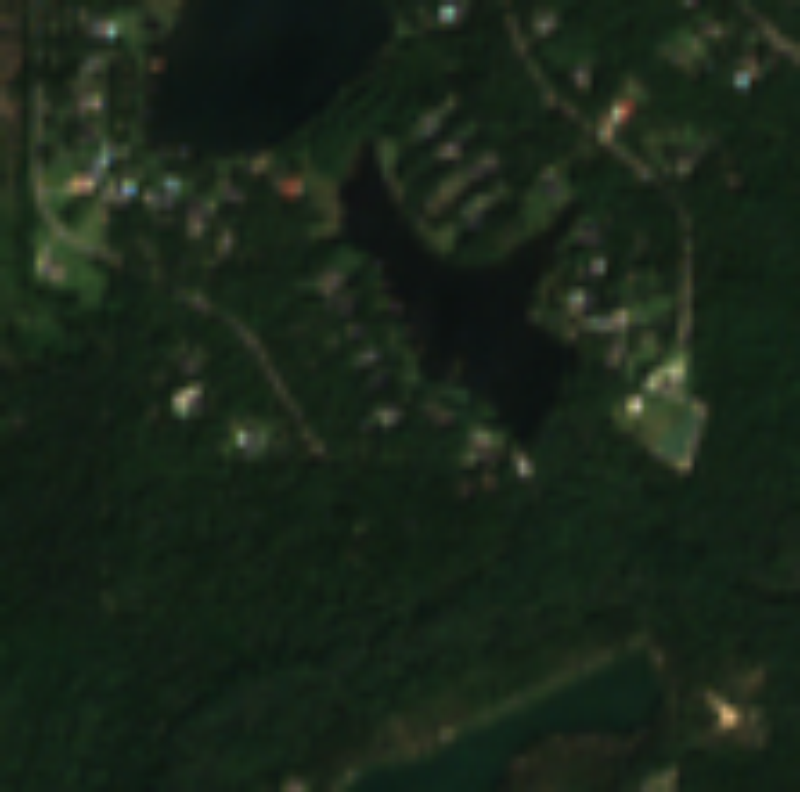

In [20]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.BILINEAR)

In [23]:
np.array(img).shape

(110, 111, 3)